In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 64
        self.data_dir = '/mnt/nasbi/homes/fan/projects/action/skeleton/data/SHREC/'
C = Config()

# Building the model

In [31]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)

In [32]:
def build_DD_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):
    M = Input(name='M', shape=(frame_l,feat_d))  
    P = Input(name='P', shape=(frame_l,joint_n,joint_d)) 
    
    FM = build_FM(frame_l,joint_n,joint_d,feat_d,filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [33]:
DD_Net = build_DD_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)

In [34]:
DD_Net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4, 512)       1740160     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 512)          0           model_3[1][0]                    
__________

## load data

In [35]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [ ]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

In [ ]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

In [11]:
# it may takes several times to reach the reported performance
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=400,
            verbose=True,
            shuffle=True,
            callbacks=[lrScheduler],
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

Train on 1960 samples, validate on 840 samples
Epoch 1/400
1960/1960 [==============================] - 10s 5ms/step - loss: 3.4202 - acc: 0.0699 - val_loss: 2.3399 - val_acc: 0.2333
Epoch 2/400
1960/1960 [==============================] - 1s 278us/step - loss: 2.9979 - acc: 0.1087 - val_loss: 2.0753 - val_acc: 0.3714
Epoch 3/400
1960/1960 [==============================] - 1s 332us/step - loss: 2.7686 - acc: 0.1429 - val_loss: 1.9081 - val_acc: 0.4595
Epoch 4/400
1960/1960 [==============================] - 1s 283us/step - loss: 2.5301 - acc: 0.1980 - val_loss: 1.8058 - val_acc: 0.4702
Epoch 5/400
1960/1960 [==============================] - 1s 359us/step - loss: 2.3672 - acc: 0.2459 - val_loss: 1.7739 - val_acc: 0.4631
Epoch 6/400
1960/1960 [==============================] - 0s 250us/step - loss: 2.1765 - acc: 0.2949 - val_loss: 1.6809 - val_acc: 0.4786
Epoch 7/400
1960/1960 [==============================] - 1s 360us/step - loss: 2.0163 - acc: 0.3485 - val_loss: 1.5215 - val_acc: 0.

Epoch 61/400
1960/1960 [==============================] - 1s 354us/step - loss: 0.1521 - acc: 0.9760 - val_loss: 0.3010 - val_acc: 0.9143
Epoch 62/400
1960/1960 [==============================] - 1s 276us/step - loss: 0.1346 - acc: 0.9811 - val_loss: 0.2938 - val_acc: 0.9179
Epoch 63/400
1960/1960 [==============================] - 1s 383us/step - loss: 0.1352 - acc: 0.9801 - val_loss: 0.2852 - val_acc: 0.9202
Epoch 64/400
1960/1960 [==============================] - 1s 288us/step - loss: 0.1208 - acc: 0.9811 - val_loss: 0.2799 - val_acc: 0.9226
Epoch 65/400
1960/1960 [==============================] - 1s 347us/step - loss: 0.1283 - acc: 0.9796 - val_loss: 0.2771 - val_acc: 0.9250
Epoch 66/400
1960/1960 [==============================] - 1s 273us/step - loss: 0.1172 - acc: 0.9857 - val_loss: 0.2779 - val_acc: 0.9238
Epoch 67/400
1960/1960 [==============================] - 1s 327us/step - loss: 0.1260 - acc: 0.9816 - val_loss: 0.2783 - val_acc: 0.9238
Epoch 68/400
1960/1960 [==========

Epoch 121/400
1960/1960 [==============================] - 1s 315us/step - loss: 0.0594 - acc: 0.9944 - val_loss: 0.2212 - val_acc: 0.9464
Epoch 122/400
1960/1960 [==============================] - 1s 258us/step - loss: 0.0567 - acc: 0.9949 - val_loss: 0.2205 - val_acc: 0.9464
Epoch 123/400
1960/1960 [==============================] - 1s 293us/step - loss: 0.0554 - acc: 0.9954 - val_loss: 0.2197 - val_acc: 0.9464
Epoch 124/400
1960/1960 [==============================] - 1s 277us/step - loss: 0.0578 - acc: 0.9923 - val_loss: 0.2191 - val_acc: 0.9464
Epoch 125/400
1960/1960 [==============================] - 1s 336us/step - loss: 0.0633 - acc: 0.9913 - val_loss: 0.2184 - val_acc: 0.9464
Epoch 126/400
1960/1960 [==============================] - 0s 238us/step - loss: 0.0579 - acc: 0.9929 - val_loss: 0.2176 - val_acc: 0.9464
Epoch 127/400
1960/1960 [==============================] - 1s 311us/step - loss: 0.0610 - acc: 0.9918 - val_loss: 0.2167 - val_acc: 0.9464
Epoch 128/400
1960/1960 [==

Epoch 180/400
1960/1960 [==============================] - 1s 437us/step - loss: 0.0502 - acc: 0.9964 - val_loss: 0.2019 - val_acc: 0.9464
Epoch 181/400
1960/1960 [==============================] - 1s 517us/step - loss: 0.0520 - acc: 0.9954 - val_loss: 0.2018 - val_acc: 0.9464
Epoch 182/400
1960/1960 [==============================] - 1s 365us/step - loss: 0.0579 - acc: 0.9954 - val_loss: 0.2016 - val_acc: 0.9464
Epoch 183/400
1960/1960 [==============================] - 1s 534us/step - loss: 0.0552 - acc: 0.9939 - val_loss: 0.2015 - val_acc: 0.9464
Epoch 184/400
1960/1960 [==============================] - 1s 391us/step - loss: 0.0614 - acc: 0.9934 - val_loss: 0.2013 - val_acc: 0.9464
Epoch 185/400
1960/1960 [==============================] - 1s 521us/step - loss: 0.0652 - acc: 0.9918 - val_loss: 0.2012 - val_acc: 0.9464
Epoch 186/400
1960/1960 [==============================] - 1s 370us/step - loss: 0.0556 - acc: 0.9944 - val_loss: 0.2011 - val_acc: 0.9464
Epoch 187/400
1960/1960 [==

Epoch 239/400
1960/1960 [==============================] - 1s 434us/step - loss: 0.0525 - acc: 0.9944 - val_loss: 0.1973 - val_acc: 0.9452
Epoch 240/400
1960/1960 [==============================] - 1s 366us/step - loss: 0.0545 - acc: 0.9969 - val_loss: 0.1973 - val_acc: 0.9452
Epoch 241/400
1960/1960 [==============================] - 1s 479us/step - loss: 0.0516 - acc: 0.9964 - val_loss: 0.1972 - val_acc: 0.9452
Epoch 242/400
1960/1960 [==============================] - 1s 408us/step - loss: 0.0584 - acc: 0.9934 - val_loss: 0.1971 - val_acc: 0.9452
Epoch 243/400
1960/1960 [==============================] - 1s 514us/step - loss: 0.0609 - acc: 0.9939 - val_loss: 0.1970 - val_acc: 0.9452
Epoch 244/400
1960/1960 [==============================] - 1s 470us/step - loss: 0.0556 - acc: 0.9934 - val_loss: 0.1969 - val_acc: 0.9452
Epoch 245/400
1960/1960 [==============================] - 1s 611us/step - loss: 0.0591 - acc: 0.9939 - val_loss: 0.1968 - val_acc: 0.9452
Epoch 246/400
1960/1960 [==

Epoch 298/400
1960/1960 [==============================] - 1s 399us/step - loss: 0.0546 - acc: 0.9959 - val_loss: 0.1942 - val_acc: 0.9476
Epoch 299/400
1960/1960 [==============================] - 1s 499us/step - loss: 0.0569 - acc: 0.9939 - val_loss: 0.1942 - val_acc: 0.9476
Epoch 300/400
1960/1960 [==============================] - 1s 480us/step - loss: 0.0588 - acc: 0.9918 - val_loss: 0.1942 - val_acc: 0.9476
Epoch 301/400
1960/1960 [==============================] - 1s 594us/step - loss: 0.0526 - acc: 0.9954 - val_loss: 0.1942 - val_acc: 0.9476
Epoch 302/400
1960/1960 [==============================] - 1s 376us/step - loss: 0.0518 - acc: 0.9949 - val_loss: 0.1941 - val_acc: 0.9476
Epoch 303/400
1960/1960 [==============================] - 1s 474us/step - loss: 0.0593 - acc: 0.9939 - val_loss: 0.1941 - val_acc: 0.9476
Epoch 304/400
1960/1960 [==============================] - 1s 405us/step - loss: 0.0576 - acc: 0.9939 - val_loss: 0.1941 - val_acc: 0.9476
Epoch 305/400
1960/1960 [==

Epoch 357/400
1960/1960 [==============================] - 1s 305us/step - loss: 0.0600 - acc: 0.9934 - val_loss: 0.1930 - val_acc: 0.9464
Epoch 358/400
1960/1960 [==============================] - 0s 251us/step - loss: 0.0563 - acc: 0.9954 - val_loss: 0.1929 - val_acc: 0.9464
Epoch 359/400
1960/1960 [==============================] - 0s 241us/step - loss: 0.0610 - acc: 0.9913 - val_loss: 0.1929 - val_acc: 0.9476
Epoch 360/400
1960/1960 [==============================] - 0s 255us/step - loss: 0.0492 - acc: 0.9949 - val_loss: 0.1929 - val_acc: 0.9476
Epoch 361/400
1960/1960 [==============================] - 1s 275us/step - loss: 0.0527 - acc: 0.9939 - val_loss: 0.1929 - val_acc: 0.9476
Epoch 362/400
1960/1960 [==============================] - 0s 224us/step - loss: 0.0571 - acc: 0.9929 - val_loss: 0.1928 - val_acc: 0.9476
Epoch 363/400
1960/1960 [==============================] - 1s 259us/step - loss: 0.0517 - acc: 0.9959 - val_loss: 0.1928 - val_acc: 0.9476
Epoch 364/400
1960/1960 [==

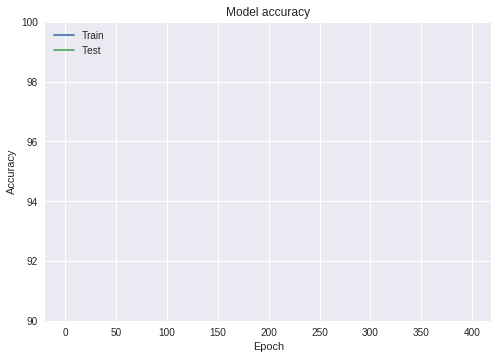

In [27]:
# Plot training & validation accuracy values
plt.ylim(90,100)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [21]:
DD_Net.save_weights('weights/coarse_heavy.h5')

## Training with frame_sampling

In [24]:
lr = 5e-6
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])

In [ ]:
epochs = 20
for e in range(epochs):
    print('epoch{}'.format(e))
    X_0 = []
    X_1 = []
    Y = []
    
    for i in tqdm(range(len(Train['pose']))): 
    
        label = np.zeros(C.clc_coarse)
        label[Train['coarse_label'][i]-1] = 1 
        
        p = np.copy(Train['pose'][i]).reshape([-1,22,3])
        p = sampling_frame(p,C)
       
        p = normlize_range(p)
        M = get_CG(p,C)
        
        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
   

    DD_Net.fit([X_0,X_1],Y,
            batch_size=len(Y),
            epochs=1,
            verbose=True,
            shuffle=True,
            validation_data=([X_test_0,X_test_1],Y_test)      
            )

# Plotting confusion matrix

In [28]:
Y_pred = DD_Net.predict([X_test_0,X_test_1])

In [29]:
labels = ['Grab', 'Tap', 'Expand', 'Pinch', 'RC', 'RCC', 'SR', 'SL', 'SU', 'SD', 'SX', 'S+', 'SV', 'Shake']

y_true = []
for i in np.argmax(Y_test,axis=1):
    y_true.append(labels[i])
    
y_pred = []
for i in np.argmax(Y_pred,axis=1):
    y_pred.append(labels[i])

In [30]:
cm_analysis(y_true,y_pred, 'images/SHREC_14.png', labels, ymap=None, figsize=(8,8))